<a href="https://colab.research.google.com/github/anupamamnair/anupamamnair.github.io/blob/master/DSC613_LA9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSC 613 Big Data Analytics

## Lab Assessment 9


---


Author: ANUPAMA M NAIR

Roll No: 2024MCS120004

### Linear Regression using PySpark MLlib

1. Installing dependencies

In [41]:
# ANUPAMA_M_NAIR_2024MCS120004
!apt-get update -y
!apt-get install openjdk-11-jdk -y
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"
!pip install pyspark

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

2. Load the dataset into a Spark DataFrame and display the schema and first 5 rows.

In [42]:
# ANUPAMA_M_NAIR_2024MCS120004
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row
from pyspark.sql.functions import col, sum
from pyspark.ml.linalg import Vectors
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("HousePriceAnalysis").getOrCreate()
df = spark.read.csv("house_price.csv", header=True, inferSchema=True)
df.printSchema()
df.show(5)

root
 |-- area: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- price: double (nullable = true)

+----+--------+---+------+
|area|bedrooms|age| price|
+----+--------+---+------+
|3974|       1|  2|433.77|
|1660|       5| 13|316.97|
|2094|       5|  2|357.33|
|1930|       1| 20|216.61|
|1895|       5|  1|337.09|
+----+--------+---+------+
only showing top 5 rows



3. Handle missing values (if any) and convert all feature columns into a
feature vector using VectorAssembler.

In [43]:
# ANUPAMA_M_NAIR_2024MCS120004
# Check for missing values
df.select(*(sum(col(c).isNull().cast("integer")).alias(c) for c in df.columns)).show()

print("No values seem to be missing")
# Convert feature columns into a feature vector
feature_cols = ["area", "bedrooms", "age"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df = assembler.transform(df)

print("\n\nData post craeting feature vector")
df.show(5)

+----+--------+---+-----+
|area|bedrooms|age|price|
+----+--------+---+-----+
|   0|       0|  0|    0|
+----+--------+---+-----+

No values seem to be missing


Data post craeting feature vector
+----+--------+---+------+-----------------+
|area|bedrooms|age| price|         features|
+----+--------+---+------+-----------------+
|3974|       1|  2|433.77| [3974.0,1.0,2.0]|
|1660|       5| 13|316.97|[1660.0,5.0,13.0]|
|2094|       5|  2|357.33| [2094.0,5.0,2.0]|
|1930|       1| 20|216.61|[1930.0,1.0,20.0]|
|1895|       5|  1|337.09| [1895.0,5.0,1.0]|
+----+--------+---+------+-----------------+
only showing top 5 rows



4. Split the dataset into training (70%) and testing (30%) sets.

In [44]:
# ANUPAMA_M_NAIR_2024MCS120004
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)
print("Training dataset size:", train_data.count())
print("Testing dataset size:", test_data.count())

Training dataset size: 374
Testing dataset size: 126


5. Build a Linear Regression model using PySpark MLlib to predict price.
6. Print the following model evaluation metrics:
* Coefficients & Intercept
* RMSE (Root Mean Squared Error)
* R² (Coefficient of Determination)

In [45]:
# ANUPAMA_M_NAIR_2024MCS120004
# Building model
lr = LinearRegression(featuresCol="features", labelCol="price")
modelLR = lr.fit(train_data)
predictions = modelLR.transform(test_data)

# Evaluate the model
evaluator_rmse = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)

print(f"Coefficients: {modelLR.coefficients}")
print(f"Intercept: {modelLR.intercept}")
print(f"Root Mean Squared Error = {rmse}")
print(f"R Squared = {r2}")

print("\nSample Predictions")
predictions.select("price", "prediction", "features").show(5)

Coefficients: [0.0896435378738325,24.86218596347921,-1.2296019948174624]
Intercept: 51.92565875625587
Root Mean Squared Error = 17.32046704239773
R Squared = 0.9661416974986048

Sample Predictions
+------+------------------+----------------+
| price|        prediction|        features|
+------+------------------+----------------+
|165.15|179.98771163466142|[816.0,3.0,16.0]|
|115.66| 115.9817409946788|[835.0,1.0,29.0]|
|126.41|130.85201600577838|[850.0,1.0,18.0]|
|179.61| 137.0254335152819|[864.0,1.0,14.0]|
|263.85|250.97245729717773| [916.0,5.0,6.0]|
+------+------------------+----------------+
only showing top 5 rows



7. Predict the price of a new house with:
* area = 2000 sq. ft
* bedrooms = 3
* age = 10 years

In [46]:
# ANUPAMA_M_NAIR_2024MCS120004
test_data = Row(area=2000, bedrooms=3, age=10)
new_df = spark.createDataFrame([test_data])

new_df = assembler.transform(new_df)
predicted_price_df = modelLR.transform(new_df)

predicted_price = predicted_price_df.select("prediction").collect()[0][0]
print(f"Predicted price for the new house: {predicted_price:.2f}")

Predicted price for the new house: 293.50


8. Plot the predicted vs actual values using Matplotlib to visualize model accuracy.

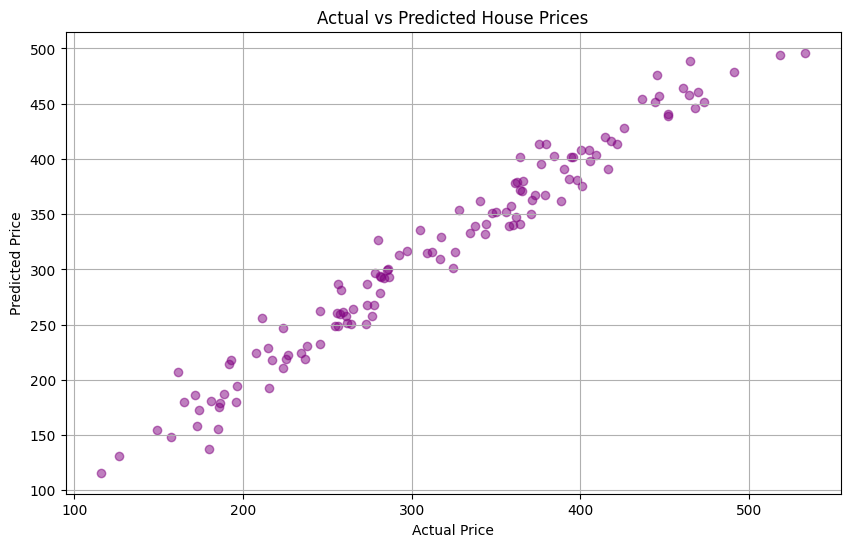

In [47]:
# ANUPAMA_M_NAIR_2024MCS120004
actual_prices = predictions.select("price").collect()
predicted_prices = predictions.select("prediction").collect()

actual_values = [row[0] for row in actual_prices]
predicted_values = [row[0] for row in predicted_prices]

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5, color='purple')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted House Prices")
plt.grid(True)
plt.show()